In [3]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
%matplotlib inline

# Занятие 15
# Алгебра
## Кривые второго порядка на плоскости: гипербола

In [102]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)

    def asymptote(self, x='x', y='y', equation=False):
      """
      A method that returns asymptotes either as equations or expressions.
      """
      x = _symbol(x, real=True)
      y = _symbol(y, real=True)

      if(equation):
        y1 = Eq(y, self.center.y + self.vradius/self.hradius*(x - self.center.x))
        y2 = Eq(y, self.center.y - self.vradius/self.hradius*(x - self.center.x))
        return [y1, y2]

    def directrix(self, x='x', equation=False):
      """
      A method that returns the directrix.
      """

      x = _symbol(x, real=True)

      if(equation):
        x1 = Eq(x, self.center.x + self.hradius**2/self.focus_distance)
        x2 = Eq(x, self.center.x - self.hradius**2/self.focus_distance)
        return [x1, x2]

    def asymptoteTurned(self, alpha, x='x', y='y', equation=True):
      """
      A method that returns asymptotes either as equations or expressions.
      """
      x = _symbol(x, real=True)
      y = _symbol(y, real=True)

      k1 = (self.vradius + self.hradius*tan(alpha))/(self.hradius - self.vradius*tan(alpha))
      k2 = (-self.vradius + self.hradius*tan(alpha))/(self.hradius - self.vradius*tan(alpha))

      if(equation):
        y1 = Eq(y, self.center.y + k1*(x - self.center.x))
        y2 = Eq(y, self.center.y + k2*(x - self.center.x))
        return [y1, y2]

    def directrixTurned(self, alpha, x='x', y='y', equation=True):
      """
      A method that returns the directrix.
      """

      x = _symbol(x, real=True)
      y = _symbol(y, real=True)

      if(equation):
        y1 = Eq(y, self.center.y - cot(alpha)*(x - self.center.x) + self.hradius**2/self.focus_distance*sqrt(1 + cot(alpha)))
        y2 = Eq(y, self.center.y - cot(alpha)*(x - self.center.x) - self.hradius**2/self.focus_distance*sqrt(1 + cot(alpha)))
        return [y1, y2]

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [84]:
hyp1 = Hyperbola(center = Point(1, 2),  hradius=12, vradius=5)
display('эксцентриситет: ', hyp1.eccentricity,
        'фокусное растояние: ', hyp1.focus_distance,
        'фокусы: ', hyp1.foci,
        'periapsis: ', hyp1.periapsis,
        'уравнение хиперболы: ', hyp1.equation(),)

'эксцентриситет: '

13/12

'фокусное растояние: '

13

'фокусы: '

(Point2D(-12, 2), Point2D(14, 2))

'periapsis: '

1

'уравнение хиперболы: '

(x/12 - 1/12)**2 - (y/5 - 2/5)**2 - 1

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [85]:
display('Асимптоты:', *hyp1.asymptote(equation = True),
        'Директрисы: ', *hyp1.directrix(equation=True))

'Асимптоты:'

Eq(y, 5*x/12 + 19/12)

Eq(y, 29/12 - 5*x/12)

'Директрисы: '

Eq(x, 157/13)

Eq(x, -131/13)

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

In [68]:
hyp2 = hyp1.equation(_slope=tan(pi/6))
display(hyp2)

(x + sqrt(3)*(y - 2)/3 - 1)**2/192 - 3*(y - sqrt(3)*(x - 1)/3 - 2)**2/100 - 1

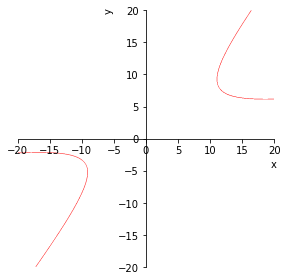

In [72]:
dict_free = {str(a): a for a in hyp2.free_symbols}
plot_implicit(hyp2, (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
 line_color='r', aspect_ratio=(1, 1))


## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

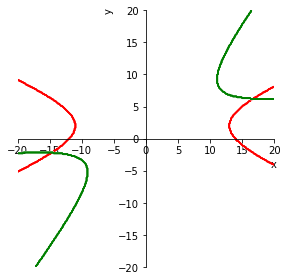

In [77]:
eq1 = hyp1.equation(x='x', y='y')
dict_free = {str(a): a for a in eq1.free_symbols}
p = plot_implicit(eq1, (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
 line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)
p.extend(plot_implicit(hyp2, (dict_free['x'], -20, 20), (dict_free['y'
], -20, 20),
 line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.show()

###  Индивидуальное задание
Определить гиперболу с центром в точке $5, 0$, полуосями $7$ и $4$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\pi/4$ градусов по часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнения повернутой гиперболы, соответствующих асимптот и директрис.

In [103]:
hyp3 = Hyperbola(Point(5, 0), hradius=7, vradius=4)
display('эксцентриситет: ', hyp3.eccentricity,
        'фокусное растояние: ', hyp3.focus_distance,
        'фокусы: ', hyp3.foci,
        'periapsis: ', hyp3.periapsis,
        'уравнение хиперболы: ', hyp3.equation(),
        'уравнения асимптот: ', hyp3.asymptote(equation=True),
        'директрис: ', hyp3.directrix(equation=True))

'эксцентриситет: '

sqrt(65)/7

'фокусное растояние: '

sqrt(65)

'фокусы: '

(Point2D(5 - sqrt(65), 0), Point2D(5 + sqrt(65), 0))

'periapsis: '

-7 + sqrt(65)

'уравнение хиперболы: '

-y**2/16 + (x/7 - 5/7)**2 - 1

'уравнения асимптот: '

[Eq(y, 4*x/7 - 20/7), Eq(y, 20/7 - 4*x/7)]

'директрис: '

[Eq(x, 5 + 49*sqrt(65)/65), Eq(x, 5 - 49*sqrt(65)/65)]

In [104]:
eq3Turned = hyp3.equation(_slope=-tan(pi/4))
display('гиперболу, повернутую на  π/4  градусов по часовой стрелки', eq3Turned,
        'асимптот', *hyp3.asymptoteTurned(alpha=pi/4),
        'дирекстрис', *hyp3.directrixTurned(alpha=pi/4))

'гиперболу, повернутую на  π/4  градусов по часовой стрелки'

(x - y - 5)**2/98 - (x + y - 5)**2/32 - 1

'асимптот'

Eq(y, 11*x/3 - 55/3)

Eq(y, x - 5)

'дирекстрис'

Eq(y, -x + 5 + 49*sqrt(130)/65)

Eq(y, -x - 49*sqrt(130)/65 + 5)